# F1 Racing Analysis - Milestone 3

## Research Question

Can we predict F1 race outcomes (points and final position) using qualifying position, circuit characteristics, driver history, and constructor performance?

**Goals**:
- Predict points scored (regression)
- Predict final race position (regression/classification)
- Find most influential factors
- Evaluate with RMSE, MAE, R² for regression; accuracy, precision, recall for classification

---

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.facecolor'] = 'white'

## 1 - Data Loading and Preprocessing

### The Dataset

Dataset from Kaggle with F1 data from 1950-2024. 14 CSV files covering races, drivers, constructors, circuits, qualifying, lap times, pit stops, and standings.

**Key files**:
- `results.csv` - race results, points, positions
- `races.csv` - race info, dates, circuits
- `qualifying.csv` - qualifying results and grid positions
- `drivers.csv` - driver info
- `constructors.csv` - team info
- `circuits.csv` - circuit details

### Load the Data

In [2]:
datasets_path = 'datasets'

drivers = pd.read_csv(os.path.join(datasets_path, 'drivers.csv'))
results = pd.read_csv(os.path.join(datasets_path, 'results.csv'))
races = pd.read_csv(os.path.join(datasets_path, 'races.csv'))
constructors = pd.read_csv(os.path.join(datasets_path, 'constructors.csv'))
circuits = pd.read_csv(os.path.join(datasets_path, 'circuits.csv'))
status = pd.read_csv(os.path.join(datasets_path, 'status.csv')) 
qualifying = pd.read_csv(os.path.join(datasets_path, 'qualifying.csv'))
constructor_standings = pd.read_csv(os.path.join(datasets_path, 'constructor_standings.csv'))

results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


### Merge Datasets

Merge datasets to combine race results with qualifying, driver info, circuits, and constructor data.

In [3]:
df = results.copy()

df = pd.merge(df, qualifying[['raceId', 'driverId', 'position']].rename(columns={'position': 'qualifying_position'}), 
              on=['raceId', 'driverId'], how='left')

races_circuits = pd.merge(races, circuits[['circuitId', 'circuitRef', 'name', 'country']], on='circuitId', how='left')
df = pd.merge(df, races_circuits[['raceId', 'circuitRef', 'country']], on='raceId', how='left')
df = pd.merge(df, drivers[['driverId', 'driverRef']], on='driverId', how='left')
df = pd.merge(df, constructors[['constructorId', 'name']].rename(columns={'name': 'constructor_name'}), 
              on='constructorId', how='left')

df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,qualifying_position,circuitRef,country,driverRef,constructor_name
0,1,18,1,1,22,1,1,1,1,10.0,...,39,2,1:27.452,218.300,1,1.0,albert_park,Australia,hamilton,McLaren
1,2,18,2,2,3,5,2,2,2,8.0,...,41,3,1:27.739,217.586,1,5.0,albert_park,Australia,heidfeld,BMW Sauber
2,3,18,3,3,7,7,3,3,3,6.0,...,41,5,1:28.090,216.719,1,7.0,albert_park,Australia,rosberg,Williams
3,4,18,4,4,5,11,4,4,4,5.0,...,58,7,1:28.603,215.464,1,12.0,albert_park,Australia,alonso,Renault
4,5,18,5,1,23,3,5,5,5,4.0,...,43,1,1:27.418,218.385,1,3.0,albert_park,Australia,kovalainen,McLaren


## 2 - Exploratory Data Analysis

### Brief Data Overview

**How does the data look? What's the general feel of the numbers?**

- Total race results: 26,759 entries
- Unique races: 1,125 races
- Unique drivers: 861 drivers  
- Unique constructors: 212 teams
- Unique circuits: 77 circuits
- Time period: 1950-2024

### Data Cleaning and Preparation


In [65]:
for col in ['position', 'grid', 'qualifying_position']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df['points'] = pd.to_numeric(df['points'], errors='coerce')
df = df[(df['position'] > 0) | df['position'].isna()]
df = df[(df['grid'] > 0) | df['grid'].isna()]

df['position_gain'] = df['grid'] - df['position']

df.describe()

,resultId,raceId,driverId,constructorId,grid,position,positionOrder,points,laps,statusId,qualifying_position,position_gain
count,25121.000000,25121.000000,25121.000000,25121.000000,25121.000000,15746.000000,25121.000000,25121.000000,25121.000000,25121.000000,10407.000000,15746.000000
mean,13465.337248,554.376299,281.092831,49.552406,11.860834,7.999174,11.858644,2.115165,49.169420,13.306516,11.153839,3.019179
std,7864.395257,319.215179,288.091761,62.323111,6.830260,4.832363,6.825425,4.459427,27.997092,21.001554,6.250971,5.096853
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,-27.000000
25%,6392.000000,288.000000,55.000000,6.000000,6.000000,4.000000,6.000000,0.000000,30.000000,1.000000,6.000000,0.000000
50%,13696.000000,538.000000,170.000000,22.000000,12.000000,7.000000,12.000000,0.000000,53.000000,7.000000,11.000000,2.000000
75%,20397.000000,822.000000,404.000000,63.000000,17.000000,11.000000,17.000000,2.000000,67.000000,12.000000,16.000000,6.000000
max,26764.000000,1144.000000,862.000000,215.000000,34.000000,33.000000,34.000000,50.000000,200.000000,141.000000,26.000000,30.000000


### Feature Distributions


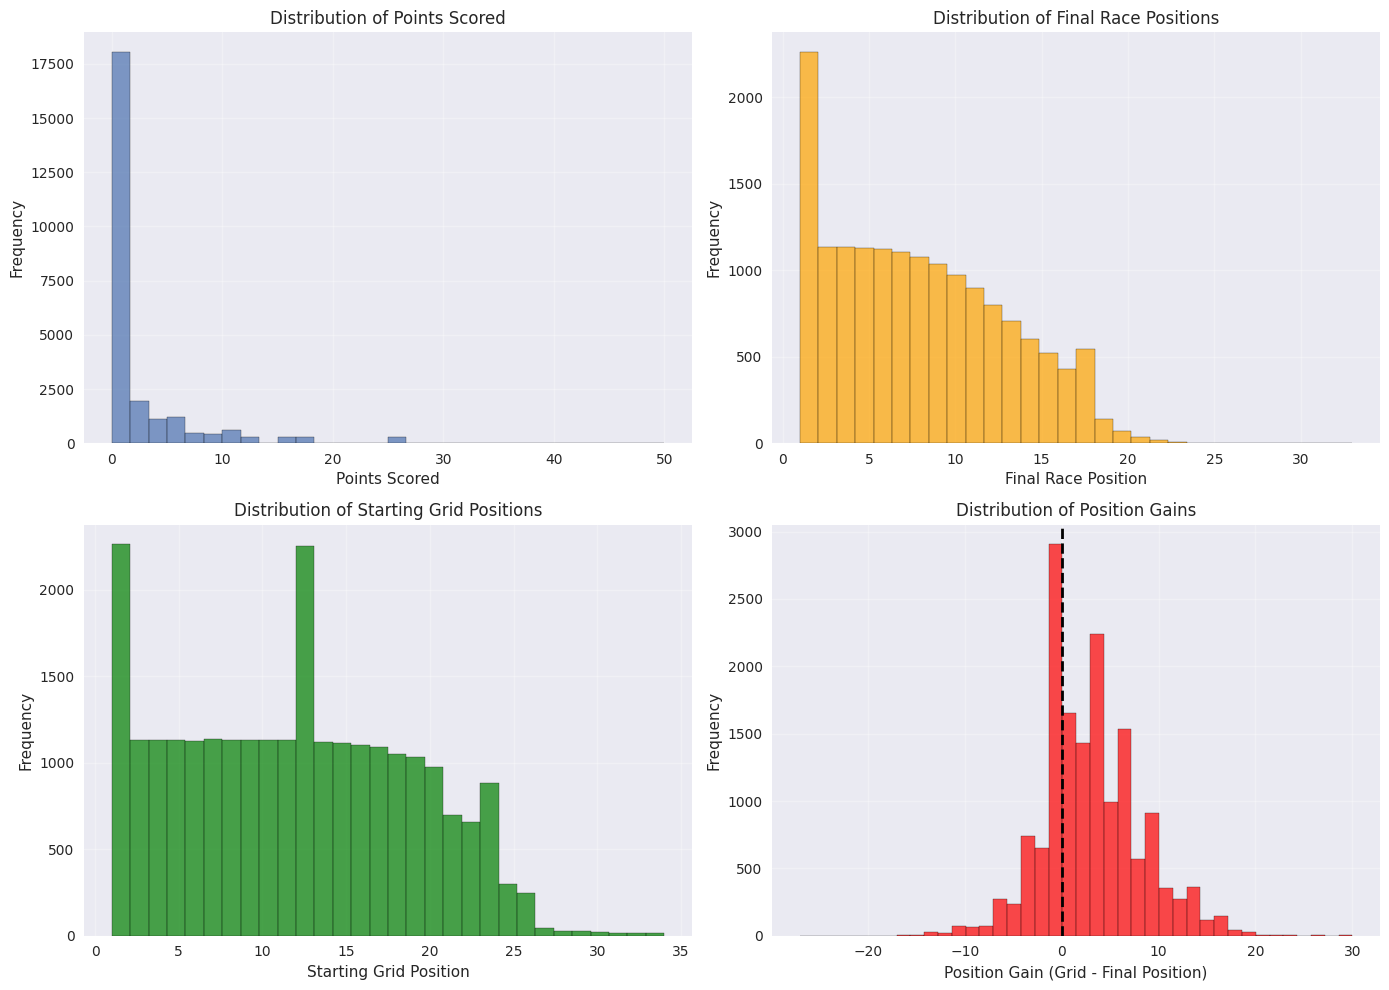

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(df['points'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Points Scored')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Points Scored')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(df['position'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Final Race Position')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Final Race Positions')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(df['grid'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Starting Grid Position')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Starting Grid Positions')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(df['position_gain'].dropna(), bins=40, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_xlabel('Position Gain (Grid - Final Position)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Position Gains')
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Points distribution is highly skewed with many zeros, indicating class imbalance. Position distributions show expected patterns with more drivers finishing in lower positions.

**Q:** What does the position gain distribution tell us about race dynamics?


### Correlation Analysis


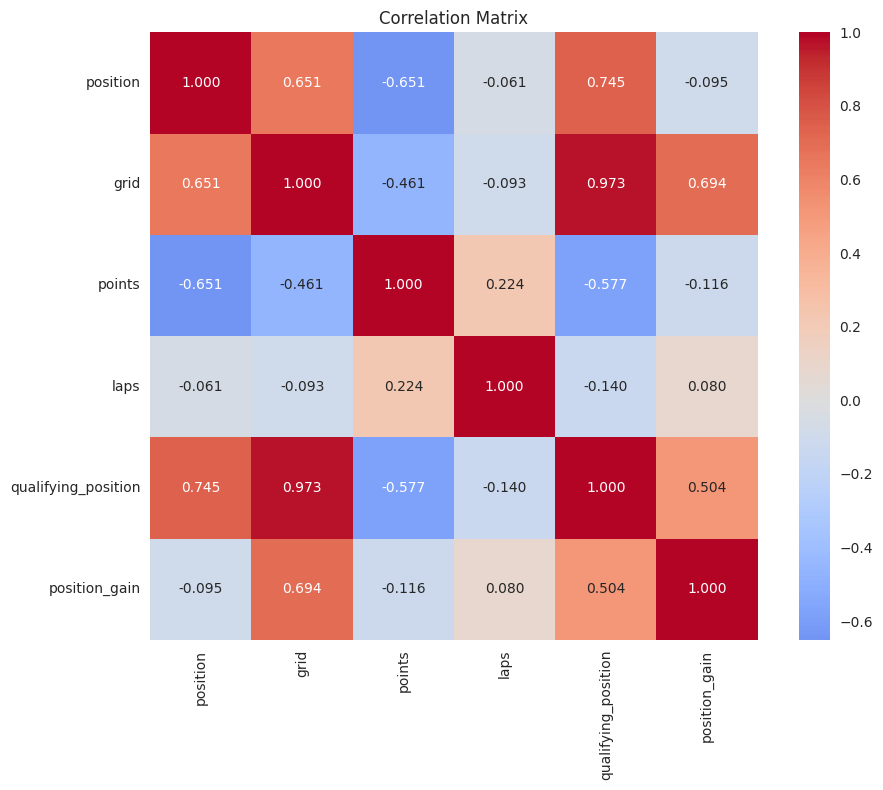

Grid vs Position: 0.651
Qualifying vs Position: 0.745
Points vs Position: -0.651


In [67]:
num_cols = ['position', 'grid', 'points', 'laps', 'qualifying_position', 'position_gain']
num_cols = [c for c in num_cols if c in df.columns]

corr = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

print(f"Grid vs Position: {corr.loc['grid', 'position']:.3f}")
if 'qualifying_position' in corr.columns:
    print(f"Qualifying vs Position: {corr.loc['qualifying_position', 'position']:.3f}")
print(f"Points vs Position: {corr.loc['points', 'position']:.3f}")


Strong correlation between starting position and final position suggests qualifying performance is a key predictor of race outcomes.

**Q:** Why might qualifying position have a stronger correlation than grid position?


### Qualifying vs Race Performance


Correlation: 0.744


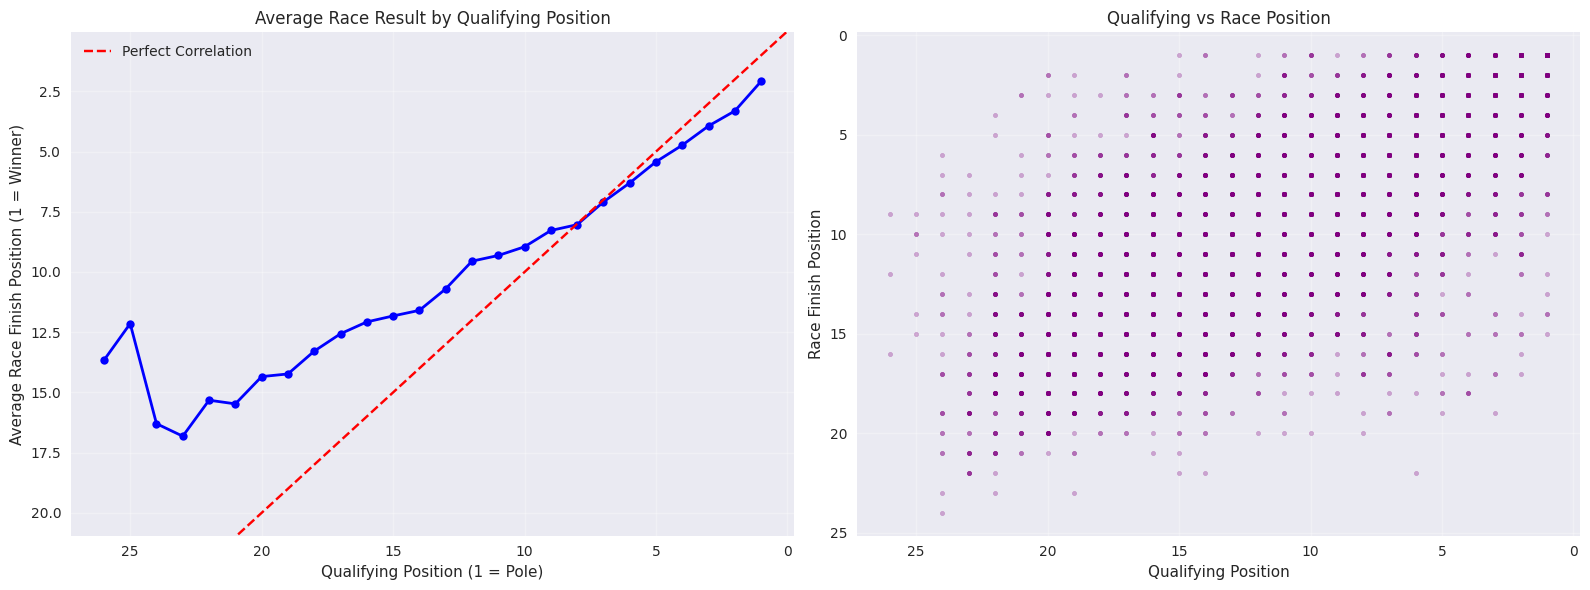

In [68]:
tmp = pd.merge(results, qualifying[['raceId', 'driverId', 'position']], 
               on=['raceId', 'driverId'], how='inner')
tmp = tmp.rename(columns={'position_x': 'race_position', 'position_y': 'qualifying_position'})

for col in ['race_position', 'qualifying_position']:
    tmp[col] = pd.to_numeric(tmp[col], errors='coerce')

tmp = tmp.dropna(subset=['race_position', 'qualifying_position'])
tmp = tmp[(tmp['race_position'] > 0) & (tmp['qualifying_position'] > 0)]

correlation = tmp[['qualifying_position', 'race_position']].corr()
print(f"Correlation: {correlation.loc['qualifying_position', 'race_position']:.3f}")

avg_finish = tmp.groupby('qualifying_position')['race_position'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(avg_finish['qualifying_position'], avg_finish['race_position'], 
         marker='o', linewidth=2, markersize=6, color='blue')
ax1.set_xlabel("Qualifying Position (1 = Pole)")
ax1.set_ylabel("Average Race Finish Position (1 = Winner)")
ax1.set_title("Average Race Result by Qualifying Position")
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)
ax1.axline((1, 1), (20, 20), color='red', linestyle='--', label='Perfect Correlation')
ax1.legend()

scatter_data = tmp.sample(min(5000, len(tmp)))
ax2.scatter(scatter_data['qualifying_position'], scatter_data['race_position'], 
           alpha=0.3, s=10, color='purple')
ax2.set_xlabel("Qualifying Position")
ax2.set_ylabel("Race Finish Position")
ax2.set_title("Qualifying vs Race Position")
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Circuit Analysis

Examine how different circuits affect position changes during races.


### Circuit Analysis


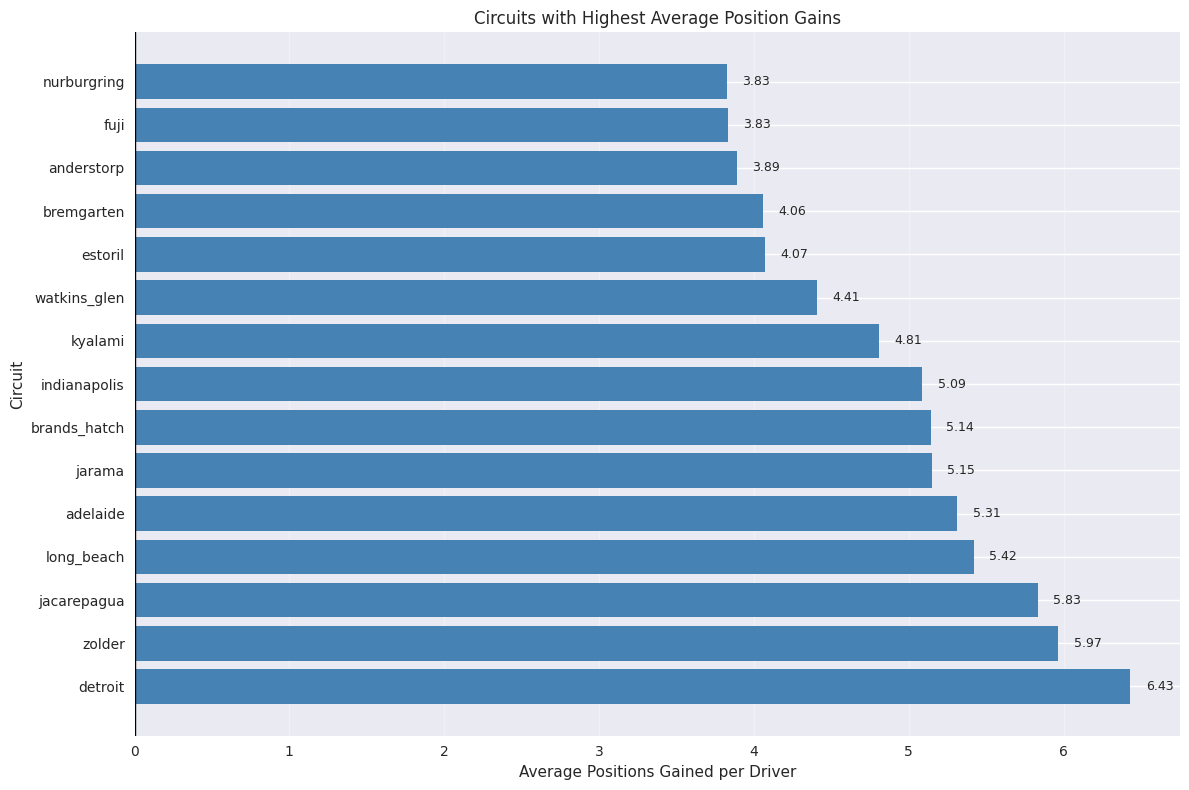

In [69]:
tmp = df.dropna(subset=['grid', 'position', 'circuitRef'])
tmp = tmp[(tmp['grid'] > 0) & (tmp['position'] > 0)]
tmp['pos_gain'] = tmp['grid'] - tmp['position']

circuit_gain = tmp.groupby('circuitRef')['pos_gain'].agg(['mean', 'count']).reset_index()
circuit_gain = circuit_gain[circuit_gain['count'] >= 50].sort_values('mean', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(circuit_gain['circuitRef'], circuit_gain['mean'], color='steelblue')
ax.set_xlabel("Average Positions Gained per Driver")
ax.set_ylabel("Circuit")
ax.set_title("Circuits with Highest Average Position Gains")
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, axis='x', alpha=0.3)

for i, (idx, row) in enumerate(circuit_gain.iterrows()):
    ax.text(row['mean'] + 0.1, i, f"{row['mean']:.2f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()


### Points Distribution


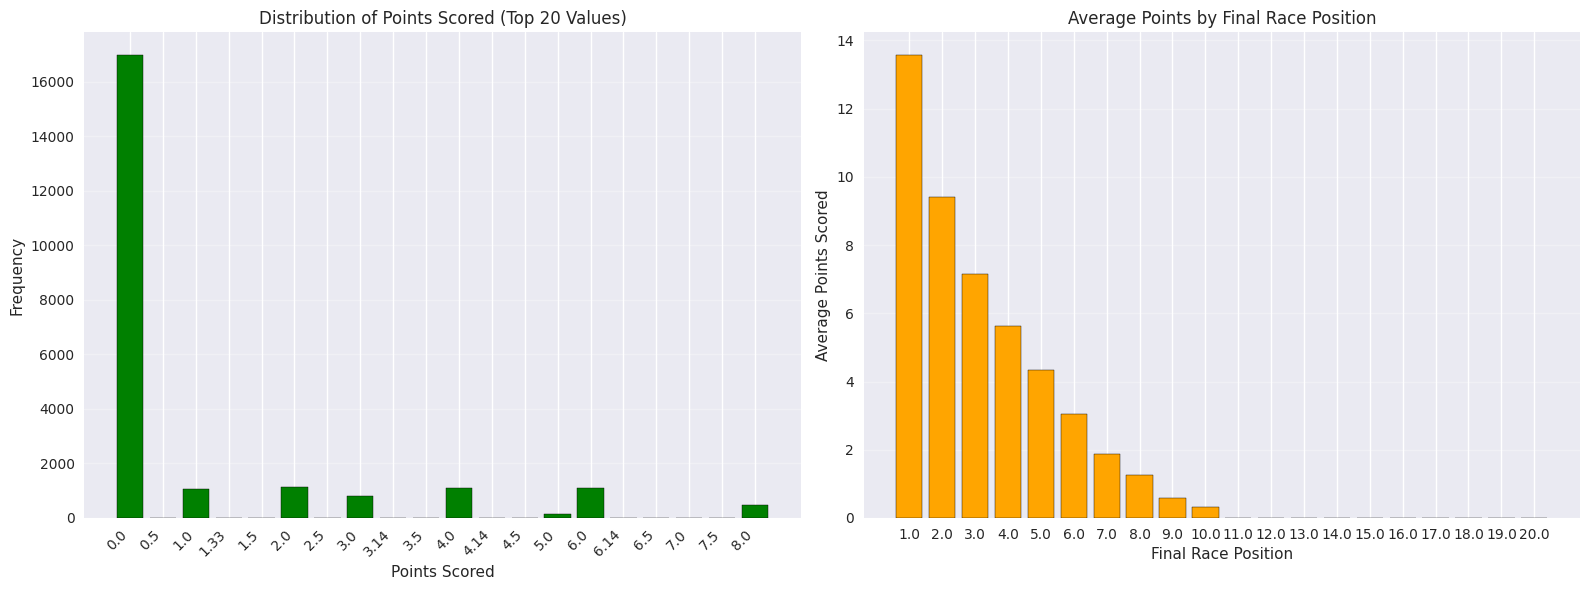

Zero points: 16,965 (67.5%)
Non-zero points: 8,156 (32.5%)


In [70]:
points_analysis = df['points'].value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

top_points = points_analysis.head(20)
ax1.bar(range(len(top_points)), top_points.values, color='green', edgecolor='black')
ax1.set_xticks(range(len(top_points)))
ax1.set_xticklabels(top_points.index, rotation=45, ha='right')
ax1.set_xlabel("Points Scored")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Points Scored (Top 20 Values)")
ax1.grid(True, axis='y', alpha=0.3)

position_points = df.groupby('position')['points'].mean().head(20)
ax2.bar(range(len(position_points)), position_points.values, color='orange', edgecolor='black')
ax2.set_xticks(range(len(position_points)))
ax2.set_xticklabels(position_points.index)
ax2.set_xlabel("Final Race Position")
ax2.set_ylabel("Average Points Scored")
ax2.set_title("Average Points by Final Race Position")
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

zero_points = (df['points'] == 0).sum()
non_zero_points = (df['points'] > 0).sum()
print(f"Zero points: {zero_points:,} ({zero_points/len(df)*100:.1f}%)")
print(f"Non-zero points: {non_zero_points:,} ({non_zero_points/len(df)*100:.1f}%)")


## 3 - Insights for Modeling Phase

**Quick Takeaways**:
- Qualifying position has 0.743 correlation with final position - strongest single predictor
- Grid position can be NaN (58.6% missing qualifying data) but less common than other missing features
- Points distribution is highly imbalanced - 67.5% zero points, 32.5% scored points
- Circuit characteristics show significant variation (5-7 position gains vs minimal gains)
- Position gains are normally distributed around 0, but vary by circuit type
- Constructor features show high importance but create 238 features after one-hot encoding

**Modeling Implications**:
- Use grid/qualifying position as primary feature (handle missing data)
- Address class imbalance for points (class weights or two-stage approach)
- Include circuit as categorical (many categories, may need regularization)
- Constructor features important but high dimensionality - consider regularization
- Position gains show non-linear patterns - consider interaction terms


## 4 - Baseline Models

Two baseline models:
1. Linear Regression - predict final race position
2. Logistic Regression - predict points/no-points

**Why baselines**: Linear relationships evident, interpretable, establish benchmarks.

**Features**: grid position, circuitRef, constructorId

**Model 1**: `position ~ grid + circuitRef + constructorId`  
**Model 2**: `points_binary ~ grid + circuitRef + constructorId`


In [71]:
df_modeling = df.dropna(subset=['position', 'grid', 'points'])
df_modeling['scored_points'] = (df_modeling['points'] > 0).astype(int)

features_to_use = ['grid', 'circuitRef', 'constructorId']
X = df_modeling[features_to_use].copy()
X_encoded = pd.get_dummies(X, columns=['circuitRef', 'constructorId'], drop_first=True)

y_position = df_modeling['position']
y_points_binary = df_modeling['scored_points']

print(f"Dataset: {X_encoded.shape[0]:,} samples, {X_encoded.shape[1]} features")
print(f"Points: {y_points_binary.sum():,} scored ({(y_points_binary.sum()/len(y_points_binary)*100):.1f}%), {(len(y_points_binary) - y_points_binary.sum()):,} no points ({((len(y_points_binary) - y_points_binary.sum())/len(y_points_binary)*100):.1f}%)")


Dataset: 15,746 samples, 238 features
Points: 8,140 scored (51.7%), 7,606 no points (48.3%)


### Linear Regression for Race Position


Test RMSE: 3.196
Test MAE: 2.483
Test R²: 0.557

Top features:
               feature       coef
170  constructorId_116  11.550267
199  constructorId_160  11.249492
197  constructorId_158   8.851042
161  constructorId_107   8.657399
169  constructorId_115   7.241744
200  constructorId_164   6.642612
229  constructorId_206   6.105331
201  constructorId_166   6.098367
230  constructorId_207   5.860880
228  constructorId_205   5.611685


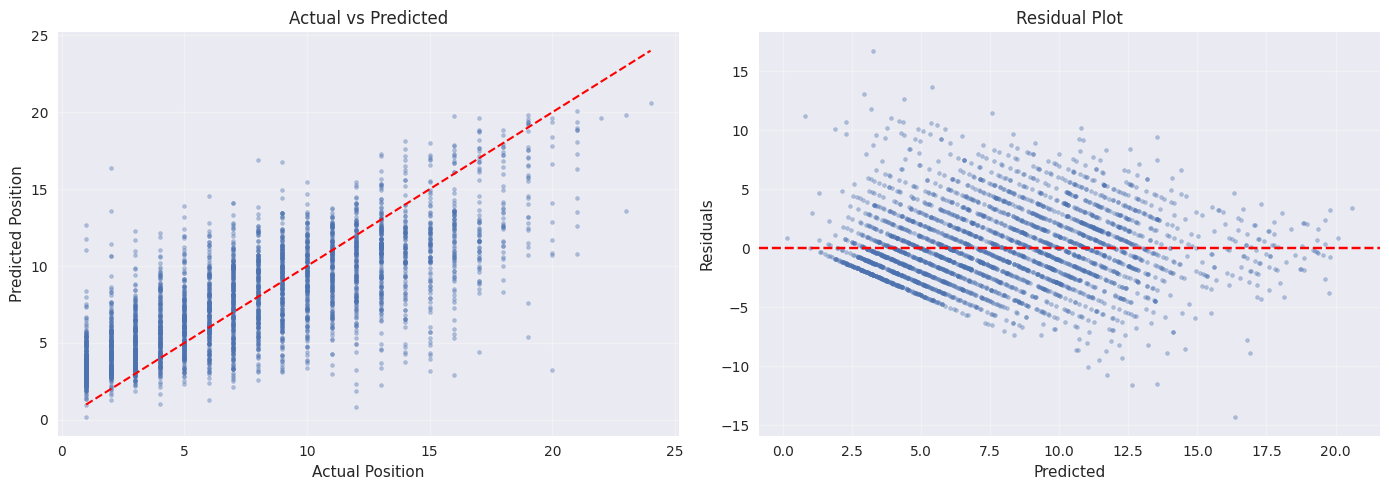

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_position, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_test = lr.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Test RMSE: {test_rmse:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Test R²: {test_r2:.3f}")

feat_imp = pd.DataFrame({
    'feature': X_encoded.columns,
    'coef': np.abs(lr.coef_)
}).sort_values('coef', ascending=False)
print(f"\nTop features:\n{feat_imp.head(10)}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(y_test, y_pred_test, alpha=0.4, s=8)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1.5)
axes[0].set_xlabel('Actual Position')
axes[0].set_ylabel('Predicted Position')
axes[0].set_title('Actual vs Predicted')
axes[0].grid(True, alpha=0.3)

residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.4, s=8)
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Logistic Regression for Points Classification


Test Accuracy: 0.792

Classification Report:
               precision    recall  f1-score   support

    No Points       0.78      0.79      0.79      1522
Scored Points       0.80      0.79      0.80      1628

     accuracy                           0.79      3150
    macro avg       0.79      0.79      0.79      3150
 weighted avg       0.79      0.79      0.79      3150


Top features:
               feature      coef
230  constructorId_207  1.963755
228  constructorId_205  1.759973
229  constructorId_206  1.689313
83     constructorId_8  1.581914
180  constructorId_131  1.538884
232  constructorId_209  1.523379
200  constructorId_164  1.487138
126   constructorId_54  1.477010
110   constructorId_35  1.446181
201  constructorId_166  1.347982


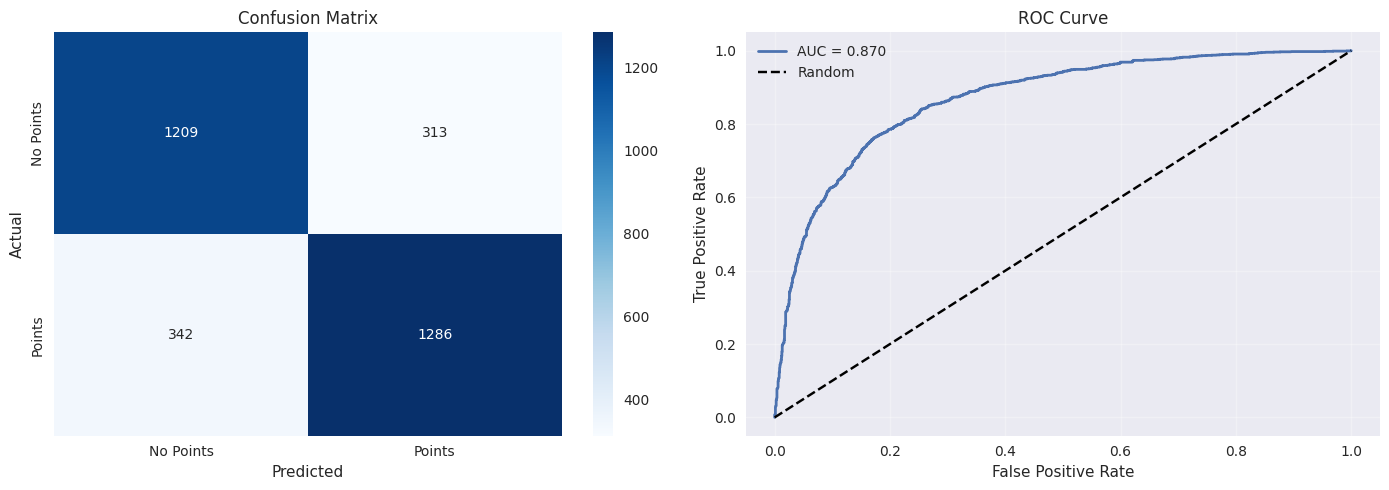

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_points_binary, test_size=0.2, random_state=42, stratify=y_points_binary
)

lr_clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_test)
y_proba = lr_clf.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Points', 'Scored Points']))

feat_imp_clf = pd.DataFrame({
    'feature': X_encoded.columns,
    'coef': np.abs(lr_clf.coef_[0])
}).sort_values('coef', ascending=False)
print(f"\nTop features:\n{feat_imp_clf.head(10)}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Points', 'Points'], yticklabels=['No Points', 'Points'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Model Summary

**Linear Regression**: Baseline for position prediction using RMSE, MAE, R².

**Logistic Regression**: Baseline for points classification using accuracy, precision, recall, ROC AUC.

Both models validate EDA findings - qualifying position is most important feature.

**Next steps**: Feature engineering, advanced models (Random Forest, Gradient Boosting), hyperparameter tuning, ensemble methods.
